In [2]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
from matplotlib import mlab;
if "bmh" in plt.style.available: plt.style.use("bmh");

# scientific
import numpy as np;
import scipy as scp;
import scipy.stats;

# python
import random;

# rise config
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'start_slideshow_at': 'selected',
              'transition':'fade',
              'scroll':False
})

{u'scroll': False,
 u'start_slideshow_at': 'selected',
 u'theme': 'simple',
 u'transition': 'fade'}

$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
$$

# EECS 545:  Machine Learning
## Lecture 07:  More Linear Classifiers
### Naive Bayes, GDA, LDA
* Instructor:  **Jacob Abernethy**
* Date:  Monday, February 1, 2016

*Lecture Exposition Credit:*  Benjamin Bray, Valli Chockalingam

## Logistics
* **No class** on Wednesday 2/3! (I'm off to San Diego!)
* My office hours this week **cancelled**
* The GSIs/IA want your attention! Very few folks are attending office hours.

## Note about Kaggle challenge grading
* Some parts of the Kaggle problems are open-ended. You can design your own features etc.
* 85% of the grade based on simply beating a basic benchmark (should not be too difficult)
* 15% of the grade based on performance on leaderboard

## New MDST Challenge Released Soon!
* The [Michigan Data Science Team](http://mdst.eecs.umich.edu) is announcing a new competition in a few days.
* Topic has to do with drunk driving accidents! <img src="images/animated_drunk_driving.gif" width=500px/>
* Meeting: **Thursday Feb. 4, 5pm in 3150 DOW**

## Outline

- Naive Bayes Classifiers
    - Independence Assumption
    - MLE and MAP Parameter Estimates
- Gaussian Discriminant Analysis
    - Quadratic Discriminant Analysis
    - Linear Discriminant Analysis
- Fisher's Linear Discriminant

## References

This lecture draws upon the following resources:

- [**[MLAPP]**](https://mitpress.mit.edu/books/machine-learning-0) Murphy, Kevin. *Machine Learning:  A Probabilistic Perspective*.  2012.
- [**[PRML]**](http://www.springer.com/us/book/9780387310732) Bishop, Christopher.  *Pattern Recognition and Machine Learning*.  2006.
- **[CS229]** Ng, Andrew.  [CS 229:  Machine Learning](http://cs229.stanford.edu/).  Autumn 2015.

# Naive Bayes Classifiers

> Follows the approach taken by **[MLAPP]**

### Review:  Generative Classifiers

A **generative classifier** learns a joint model $P(y,x) = P(x|y) P(y)$.
- The *likelihood* specifies how to generate observed features $x$ if labels $y$ are known
- The *prior* encodes beliefs about popularity of each label

Classify using the **MAP Estimation**, via Bayes' Rule:
    $$
    \hat{y} = \arg \max_y P(y | x) = \frac{P(x | y) P(y)}{P(x)}
    $$
    
--------------------
NOTES:
   - *Discriminative Models* directly model $P(C_k | x)$ and learn parameters from the training set.
   - *Generative Models* learn class-conditional densities $P(x | C_k)$ and priors $P(C_k)$

### Naive Bayes:  Problem

We will use **Naive Bayes** to solve the following classification problem:
- Categorical features $x$
- Predict discrete class label $y$

### Naive Bayes:  Spam Classification

For example, in **Spam Mail Classification**,
- Predict whether an email is `SPAM` ($y=1$) or `HAM` ($y=0$)
- Use words / metadata in the email as features

For simplicity, we can use **bag-of-words** features,
- Assume fixed vocabulary $V$ of size $|V| = D$
- Feature $x_j$, for $j \in \{1, 2, \dots, D \}$, indentifies the $j^\text{th}$ word

### Naive Bayes:  Independence Assumption

For simplicity, we assume all features are **conditionally independent** given the label,
$$
P(x | y=c) = \prod_{j=1}^D P(x_j | y=c)
$$
Features $x_k$ modeled as categorical random variables, expressed differently between classes

$$
x_j \mid y=c \;\sim\; \mathrm{Categorical}(\theta_{c})
$$

where

$$
X \;\sim\; \mathrm{Categorical}(p_i) \text{, or we would call it generalized Bernoulli}\\
\text{support: } x \in \{1,2,3,\cdots,k\}\\
\text{parameter: } p_i \text{ and } i \in \{1,2,3,\cdots,k\} \text{, } \sum_{i=1}^k p_i=1\\
P(X=i)=p_i
$$

- Same categorical distribution for each feature (not necessary)
- *each word has different probabilities across different contexts*!

### Naive Bayes:  Is Independence Justified?

Naive Bayes assumes features contribute *independently* to the class label.

> This is the *simplest possible* generative model... and an **extreme** assumption...

This model is *naive* because we would never expect features to be independent!

>  We are completely ignoring correlations between variables!

### Naive Bayes:  Is Independence Justified?

It seems not to matter that independence is often false...
- Naive Bayes performs surprisingly well on real-world data
- Naive Bayes is often used as a baseline

One reason is that the model is quite simple
- Only $O(CD)$ parameters, for $C$ classes and $D$ features
- Hence relatively immune to overfitting

### Naive Bayes:  Is Independence Justified?

There are some interesting theoretical justifications, too!

- Zhang, 2004, "[The optimality of naive Bayes.](http://www.cs.unb.ca/profs/hzhang/publications/FLAIRS04ZhangH.pdf)"
- Domingos & Pazzani, 1997, "[On the optimality of the simple Bayesian classifier under zero-one loss.](http://web.cs.ucdavis.edu/~vemuri/classes/ecs271/Bayesian.pdf)".

Apparently, dependencies between variables can "cancel out"...

### Naive Bayes:  Full Model

The full generative model of **Naive Bayes** is:

$$
\begin{align}
y       &\sim \mathrm{Categorical}(\pi) \\
x_j | y=c &\sim \mathrm{Categorical}(\theta_{c}) \quad \forall\, j = 1,\dots,D
\end{align}
$$

with parameters:
- Class-conditional probabilities $\theta = (\theta_1, \dots, \theta_C)$
    > $\theta_{c} \in \R^M$ parameterizes a dist. over vocab.
- Class priors $\pi = (\pi_1, \dots, \pi_C) \in \R^C$, which means there are C different category for $Y$  
- $\theta = (\theta_1, \dots, \theta_C)$ and $\theta_{c} \in \R^M$ means different c (i.e. when Y is in different category), $X$ can have different distribution over the vocabulary. Also $dim(\theta)=M\times C$

**NOTES**  
$Pr(Y=a)=\pi_a$ and $Pr(X_j=b|Y=a)=\theta_{b|y=a}$. Both $Y$ and $X|Y$ both categorical distributions. 

### Naive Bayes:  Parameter Estimation

**Goal:** Estimate class-conditional probabilities $\theta_c$ and class priors $\pi_c$.
- Given training data $\mathcal{D} = ( (\vec{x}_1, y_1), \dots, (\vec{x}_N, y_N))$

We will discuss the **MLE** and **MAP** parameter estimates.

    

### Naive Bayes:  Maximum Likelihood

$(\vec{x}_i, y_i=c)$ means the ith y is $c$, and the distribution of vocabulary (vector $\vec{x_c}$)
(taking spam email as example, we can say the 3rd email is spam, $y_3=1$ and the distribution over the vocabulary in 3rd email is $\vec{x_i}$. To be more detail for $\vec{x_i}$, we can assume the bag of word only has 2 words:{loan, house}. When $y$ is given, the probability of this email contain word "loan" and word "house" are $\theta_{c,1}$ and $\theta_{c,2}$ respectively )

The probability for a single data case $(\vec{x}_i, y_i=c)$ is ($\vec{x}_i=(x_{i,1},x_{i,2},x_{i,3},\cdots,x_{i,D})$, $\vec{x}_i$ is called ith bag of words)

$$
P(\vec{x}_i, y_i=c)
= P(y_i | \pi) \prod_{j=1}^D P(x_{ij} | \theta_c)
= \pi_c \prod_{j=1}^D P(x_{ij} | \theta_c)
$$

Therefore, the log-likelihood is

$$
\log P(\vec{x}_i, y_i)
= \log \pi_c + \sum_{j=1}^D \log P(x_{ij} | \theta_c)
$$

### Naive Bayes:  Maximum Likelihood

The log-likelihood given all training data $\mathcal{D}$ is then

$$
\begin{align}
\log P(\mathcal{D} | \theta, \pi)
&= \sum_{c=1}^C N_c \log\pi_c + \sum_{j=1}^D \sum_{c=1}^C \sum_{i : y_i = c} \log P(x_{ij} | \theta_{c})
\end{align}
$$

where $N_c$ is the occurrence count of class $c$ in the training data $\mathcal{D}$

----------------------------
NOTES: More specific example: spam  
D: whole data set. There are 50 emails with 10 spams(c=1) and 40 hams(c=0). When the email is classified by spam, the bag of word is {house(j=1),loan(j=2),other vocabulary(j=3)}. Otherwise, when this email is classified as ham the bag of word is {appointment(j=1), peace(j=2), other vocabulary(j=3)}. In the 10 email classified as spam, there are 2 email contain word house and 5 email contain word loan. 
$$
N=50, N_1=10, N_0=40, N_{1,1}=2, N_{0,2}=5
$$

### Naive Bayes:  Maximum Likelihood

It is easy to check (**crucial exercise!**) that the maximum likelihood estimators are:

$$
\hat{\pi}_c = \frac{N_c}{N} \quad \hat{\theta}_{cw} = \frac{N_{cw}}{N_c}
$$

- $N = $ number of examples in $\mathcal{D}$
- $N_c = $ number of examples in class $c$ in $\mathcal{D}$
- $N_{cw} = $ number of examples in class $c$ containing word $w$ in $\mathcal{D}$

### Naive Bayes:  Sparse Features

**Problem:** When working with text, features are **sparse**:
1. In training, we only see a *small, small* fraction of words in the vocabulary
2. Moreover, we won't see all words exhibited across all classes

This causes overfitting!
- What if a word (e.g. "`subject:`") occurs in every training example?
- What happens if that word never appears in testing?  (*Black Swan Paradox*)





### Naive Bayes:  Priors

**Solution:** Place Dirichlet priors on $\pi$ and $\theta_c$ to *smooth out* unknowns:

$$
\begin{align}
\pi       &\sim \mathrm{Dirichlet}(\alpha_1, \dots, \alpha_C) \\
\theta_c  &\sim \mathrm{Dirichlet}(\beta_1, \dots, \beta_M)  \quad \forall\, c=1,\dots,C \\
y         &\sim \mathrm{Categorical}(\pi)                     \\
x_j | y=c &\sim \mathrm{Categorical}(\theta_{c}) \quad \forall\, j = 1,\dots,D
\end{align}
$$

> **Recall:** The Dirichlet defines a probability distribution over vectors with nonnegative entries summing to one, i.e. categorical distributions!
$
\vec{X} \sim \mathrm{Dirichlet}(\alpha_1, \dots, \alpha_C)\\
\vec{X}=(X_1, X_2. \dots, X_C) \text{ where } x_i \in (0,1) \text{ and } \sum_{i=1}^C x_i=1\\
f(X_1=x_1, X_2=x_2, \dots, X_C=x_C)= \frac{1}{B(\alpha)}\prod_{i=1}^C x_i^{\alpha_i-1}\\
\text{where } B(\alpha)=\frac{\prod_{i=1}^C \Gamma(\alpha_i)}{\Gamma(\sum_{i=1}^C\alpha_i)}
$

### Naive Bayes:  MAP Estimation

**Exercise:**  Show that the MAP parameter estimates are

$$
\hat{\pi}_c = \frac{N_c+\alpha_c}{N + \sum_{c'} \alpha_{c'}} \quad \hat{\theta}_{cw} = \frac{N_{cw}+\beta_w}{N_c + \sum_{w'} \beta_{w'}}
$$

The Dirichlet $\alpha$ and $\beta$ parameters turn out to be **pseudocounts**!  
- We assume we've seen $\alpha_c$ examples of each class
- and $\beta_w$ examples of each word per class.

The choice $\alpha_c = \beta_w = 1$ is **Laplace Smoothing**

### Naive Bayes:  Challenge

> How should we deal with *out-of-vocabulary* words, i.e. words in the test set that we didn't include in the vocabulary during training?

# Discriminant Functions

> Uses material from **[PRML]**

### Discriminant Functions

A **discriminant function** maps an input vector to one of $C$ classes.
- Characterized by a **decision boundary**
- We will mainly focus on **linear discriminants**

### Linear Discriminant Functions

A **linear discriminant function** $y(x) = w^T x + w_0$ divides two classes in feature space
- weight vector $w \in \R^D$
- bias $w_0 \in \R$

Assign $x$ to $C_1$ if $y(x) \geq 0$ and to $C_0$ otherwise.

> See **[PRML]** section 4.1 for a discussion of multiclass problems.

### Linear Discriminant Functions

We have a linear discriminant $y(x) = w^T x + w_0$

- In two dimensions, this is a line
- In three dimensions, a plane
- In general, a **separating hyperplane**!

### How to select weights $w$?

One approach: Least Squares for classification! Choose $w$ that minimizes squared error

**Bad Idea:**  
- Treat like a regression problem $y$ vs. $x$
- Least squares is too sensitive to outliers.  (*Why?*)

<img src="images/linear-discriminant-least-squares.png">

### How to select weights $w$?

**Better Idea:**  We'll cover the following models
- Gaussian Discriminant Analysis
    - Quadratic Discriminant Analysis
    - Linear Discriminant Analysis
- Fisher's Linear Discriminant
- Perceptron Learning Algorithm

# Gaussian Discriminant Analysis

> Uses material from **[PRML]**, **[MLAPP]**, and **[CS229]**

### Review:  Multivariate Normal

A **normally distributed** random variable with mean $\mu \in \R^D$
and psd covariance matrix $\Sigma \in \R^{D \times D}$ has pdf:

$$
\mathcal{N}(x | \mu, \Sigma) = \frac{1}{Z} \exp \left\{- \frac {1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right\}
$$

with normalization constant $Z = (2\pi) ^\frac{D}{2} |\Sigma|^ \frac{1}{2}$.  Compare to the one-dimensional case:

$$
\mathcal{N}(x | \mu, \sigma^2)
= \frac{1}{\sqrt{2\pi \sigma^2}}
\exp\left\{ -\frac{(x - \mu)^2}{2 \sigma^2} \right\}
$$

### Review:  Multivariate Normal

<div style="color:red">
- when cov matrix is diagonal, we are sampling an independent normal for each coordinate
- off-diagonal entries model *correlations* between variables
</div>

### Gaussian Discriminant Analysis:  Model

Generative probabilistic model
- Predict discrete label $y$ from continuous features $x$
- Class-conditional densities are multivariate normals

$$
\begin{align}
y &\sim \mathrm{Categorical}(\pi) \\
x \mid y=c &\;\sim\; \mathcal{N}(\mu_c, \Sigma_c)
\end{align}
$$

with class priors $\pi_c$ and per-class means $\mu_c$ and covariance matrices $\Sigma_c$

### Gaussian Discriminant Analysis:  Remark

- Unlike Naive Bayes, Gaussian Discriminant Analysis models **feature correlations**
- However, if all covariance matrices are diagonal, then GDA can be seen as the continuous analogue of Naive Bayes!

### Gaussian Discriminant Analysis:  Data

Because GDA is a *generative* model, we can *generate* fake data!  (Assume uniform $\pi$)

In [3]:
def generate_gda(means, covs, num_samples):
    num_classes = len(means);
    num_samples //= num_classes;
    
    # cheat and draw equal number of samples from each gaussian
    samples = [
        np.random.multivariate_normal(means[c],covs[c],num_samples).T 
        for c in range(num_classes)
    ];
    
    return np.concatenate(samples, axis=1);

### Gaussian Discriminant Analysis:  Data

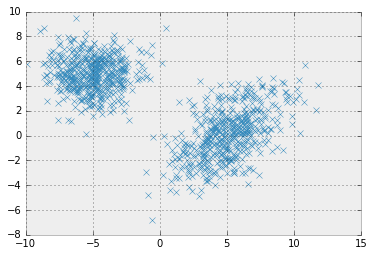

In [4]:
# define gaussians
means = [ [-5,5], [5, 0] ];
covs = [ [[3, 0], [0, 2]], [[4, 2], [2, 4]] ];
# plot
x, y = generate_gda(means, covs, 1000);
plt.plot(x, y, 'x');

### Gaussian Discriminant Analysis:  Classification

Classify a feature vector $x$ using the **posterior mode**:

$$
\begin{align}
\hat{y}(x)
&= \arg\max_c \log P(y=c | x) = \arg\max_c \log P(x|y=c)P(y=c) \\
&= \arg\max_c\left[ \log P(y=c|\pi) + \log P(x|\theta_c) \right]
\end{align}
$$

- The probability of $x$ under each class-conditional density is the distance from $x$ to the center $\mu_c$ of each class, using [**Mahalanobis distance**](https://en.wikipedia.org/wiki/Mahalanobis_distance)!
- GDA can be thought of as a **nearest-centroid classifier**!

### Gaussian Discriminant Analysis:  Decision Boundary

In [5]:
# PLOTTING CODE!  (SKIP!)
def plot_decision_contours(means, covs):
    # plt
    fig = plt.figure(figsize=(10,6));
    ax = fig.gca();
    
    # generate samples
    data_x,data_y = generate_gda(means, covs, 1000);
    ax.plot(data_x, data_y, 'x');

    # dimensions
    min_x, max_x = -10,10;
    min_y, max_y = -10,10;

    # grid
    delta = 0.025
    x = np.arange(min_x, max_x, delta);
    y = np.arange(min_y, max_y, delta);
    X, Y = np.meshgrid(x, y);
    
    # bivariate difference of gaussians
    mu1,mu2 = means;
    sigma1, sigma2 = covs;
    Z1 = mlab.bivariate_normal(X, Y, sigmax=sigma1[0][0], sigmay=sigma1[1][1], mux=mu1[0], muy=mu1[1], sigmaxy=sigma1[0][1]);
    Z2 = mlab.bivariate_normal(X, Y, sigmax=sigma2[0][0], sigmay=sigma2[1][1], mux=mu2[0], muy=mu2[1], sigmaxy=sigma2[0][1]);
    Z = Z2 - Z1;
    
    # contour plot
    ax.contour(X, Y, Z, levels=np.linspace(np.min(Z),np.max(Z),10));
    cs = ax.contour(X, Y, Z, levels=[0], c="k", linewidths=5);
    plt.clabel(cs, fontsize=10, inline=1, fmt='%1.3f')

    # plot settings
    ax.set_xlim((min_x,max_x));
    ax.set_ylim((min_y,max_y));
    
    ax.set_title("Gaussian Discriminant Analysis:  $P(y=1 | x) - P(y=0 | x)$")

### Gaussian Discriminant Analysis:  Decision Boundary

The decision boundary is **quadratic** in general, as seen from the thresholded class posterior.

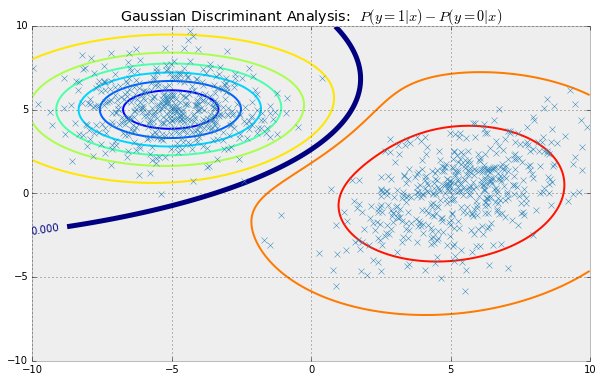

In [6]:
# define gaussians
means = [ [-5,5], [5, 0] ];
covs = [ [[3, 0], [0, 2]], [[4, 2], [2, 4]] ];

plot_decision_contours(means, covs);

### Linear Discriminant Analysis

Consider the case where covariances are **shared**, that is $\Sigma_c = \Sigma$. Recall that $P(y=c | x) \propto  P(y=c) P(x | y=c)$, so we have

$$
\begin{align}
P(y=c | x)
&\propto  \pi_c \exp\left[ -\frac{1}{2} (x-\mu_c)^T \Sigma^{-1} (x-\mu_c) \right] \\
&= \pi_c \exp\left[ \mu_c^T \Sigma^{-1} x - \frac{1}{2} x^T \Sigma^{-1} x - \frac{1}{2} \mu_c^T \Sigma^{-1} \mu_c \right] \\
&= \exp\left[ \mu_c^T \Sigma^{-1} x - \frac{1}{2} \mu_c^T \Sigma^{-1} \mu_c + \log\pi_c \right] \\ 
   & \quad \quad \quad \cdot \exp\left[  - \frac{1}{2} x^T \Sigma^{-1} x \right]
\end{align}
$$

The rightmost term is independent of $c$, so will cancel out when we normalize.

### Linear Discriminant Analysis

From the previous slide, we had
$$
P(y=c | x)
\propto \exp\left[ \mu_c^T \Sigma^{-1} x - \frac{1}{2} \mu_c^T \Sigma^{-1} \mu_c + \log\pi_c \right]
$$

Letting $\gamma_c = -\frac{1}{2} \mu_c^T \Sigma^{-1} \mu_c + \log\pi_c$ and $\beta_c = \Sigma^{-1} \mu_c$,

$$
P(y=c | x)
= \frac{\exp\left[ \beta_c^T x + \gamma_c \right]}{\sum_c \exp\left[\beta_c^T x + \gamma_c \right]}
= \mathcal{Softmax}_c(\eta)
$$

with $\eta = \left[ \beta_c^T x + \gamma_c \right]_{c=1}^C$.

### Linear Discriminant Analysis:  Decision Boundary

For binary classification, $\mathrm{Softmax(\eta)_c}$ becomes the sigmoid function.
- As with logistic regression, taking logs yields a linear function of $x$.
- Thresholding gives a **linear decision boundary**

We conclude that Gaussian Discriminant Analysis with **shared covariances** yields a linear classifier.
- Different priors move the threshold up and down, just shifting the decision boundary.

### Linear Discriminant Analysis:  Decision Boundary

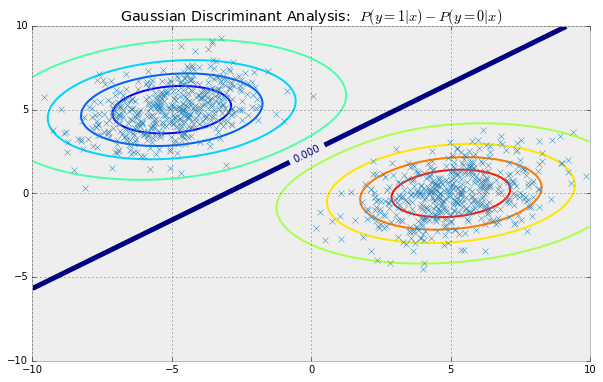

In [7]:
# define gaussians
means = [ [-5,5], [5, 0] ];
covs = [ [[3, 1], [1, 2]],
         [[3, 1], [1, 2]] ];

plot_decision_contours(means, covs);

### Gaussian Discriminant Analysis:  MLE

Maximum Likelihood estimation would proceed similarly to Naive Bayes,
- Fit a per-class Gaussian by estimating the mean and covariance of examples within each class

$$
\hat{\mu}_c = \frac{1}{N_c} \sum_{i : y_i = c} x_i
\quad
\hat{\Sigma}_c = \frac{1}{N_c} \sum_{i : y_i = c} (x_i - \hat{\mu}_c)(x_i - \hat{\mu}_c)^T
$$

> Left as an exercise!


## GDA vs. Logistic Regression

For a $D$-dimensional feature space, 
- Logistic Regression must fit $D$ parameters.
- Gaussian Discriminant Analysis has to fit 
    * $C \cdot D$ parameters for each class mean $\mu_c$
    * $D(D+1)/2$ params for the shared covariance mtx
- Logistic regression has fewer parameters and is more flexible about data distribution!
- GDA makes stronger modeling assumptions, and works better (only) when assumptions hold (approximately)

# Fisher's Linear Discriminant

(for binary classification)

> Uses material from **[PRML]**

### Fisher's Linear Discriminant

Use $\mathbf{w}$ to project $x$ onto one dimension

- If $\mathbf{w}^T x \geq -w_0$ then assign $\mathbf{x}$ to class 1, else to class 0.

Select a projection $w$ that best "separates" the classes, i.e., both

- Maximizes class separation (distance between means)
- Minimizes class variance

## Fisher's Linear Discriminant

Maximizing separation alone:

<img src="images/separation_alone.png">

## Fisher's Linear Discriminant

Maximizing both inter-class separation and minimizing in-class variance:

<img src="images/separation_and_variance.png">

### Fisher's Linear Discriminant:  Objective

**Goal 1:**  Maximize the *distance between classes*

$$
\begin{gather}
\text{maximize}
\quad
m_1 - m_0 
\equiv w^T (\vec{m}_1 - \vec{m}_0) \\
\vec{m}_k = \frac{1}{N_k} \sum_{i: y_i = c} x_i
\end{gather}
$$

In particular, maximize distance between projected means

### Fisher's Linear Discriminant:  Objective

**Goal 2:**  Minimize the *variance within classes*

$$
\text{minimize}
\quad
s_1^2 + s_0^2
\equiv 
\sum_{i: y_i = 1} (\vec{w}^T \vec{x}_i - m_1)^2 + 
\sum_{i: y_i = 0} (\vec{w}^T \vec{x}_i - m_0)^2
$$

### Fisher's Linear Discriminant:  Objective

**Objective Function:** Encodes both *Goal 1* and *Goal 2*:

$$
\text{maximize} \quad J(\vec{w}) = \frac{(m_1-m_0)^2}{s_1^2 + s_0^2}
$$

### Fisher's Linear Discriminant:  Objective

Using $ (m_1 - m_0) = \vec{w}^T (\vec{m}_1 - \vec{m}_0)$ we can rewrite the numerator:

$$
\begin{align}
|| m_1 - m_0 ||^2 &= \vec{w}^T (\vec{m}_1 - \vec{m}_0) (\vec{m}_1 - \vec{m}_0)^T \vec{w} \\
                  &= \vec{w}^T S_B \vec{w}
\end{align}
$$

Where $S_B$ is the **between-class scatter matrix**
- tells us how much the means of different features covary, or
- how correlated they are (without regard for scaling)

### Fisher's Linear Discriminant:  Objective

Define the **within-class scatter matrix**

$$
S_W = \sum_{i : y_i = 1} (x_i - \vec{m}_1) (x_i - \vec{m}_1)^T +
      \sum_{i : y_i = 0} (x_i - \vec{m}_0) (x_i - \vec{m}_0)^T 
$$

As an exercise, check that

$$
s_1^2 + s_0^2 = \vec{w}^T S_W \vec{w}
$$

### Fisher's Linear Discriminant:  Objective

We can know rewrite the objective explicitly in terms of $w$,


$$
\text{maximize} \quad J(\vec{w}) = \frac{(m_1-m_0)^2}{s_1^2 + s_0^2} = \frac{\vec{w}^T S_B \vec{w}}{\vec{w}^T S_W \vec{w}}
$$

See **[PRML]** for a derivation of the solution $\vec{w} = S_W^{-1} ( \vec{m}_1 - \vec{m}_0 )$